In [7]:
import os
import random
import shutil
import pandas as pd
import pickle
import numpy as np
import seaborn as sns

from sklearn.datasets import load_files

# from keras.utils import to_categorical # Changed np_utils to to_categorical
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

import warnings
warnings.filterwarnings('ignore')

In [8]:
import os, random, shutil

def prepare_data(base_input_path, base_output_path, train_ratio=0.7, val_ratio=0.15):
    labels = [d for d in os.listdir(base_input_path) if os.path.isdir(os.path.join(base_input_path, d))]
    for label in labels:
        input_folder = os.path.join(base_input_path, label)
        images = os.listdir(input_folder)
        random.shuffle(images)
        
        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        # Directories
        train_class_dir = os.path.join(base_output_path, 'training', label)
        val_class_dir = os.path.join(base_output_path, 'validation', label)
        test_class_dir = os.path.join(base_output_path, 'testing', label)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        # Copy images
        for i, img_name in enumerate(images):
            src_path = os.path.join(input_folder, img_name)
            if i < n_train:
                dest_path = os.path.join(train_class_dir, img_name)
            elif i < n_train + n_val:
                dest_path = os.path.join(val_class_dir, img_name)
            else:
                dest_path = os.path.join(test_class_dir, img_name)
            shutil.copy(src_path, dest_path)

# Example usage:
prepare_data(
    base_input_path="/kaggle/input/distraction-driver-detection/imgs/train",
    base_output_path="/kaggle/working/master_data",
    train_ratio=0.7,
    val_ratio=0.15
)


In [9]:
train_dir = "/kaggle/working/master_data/training"
validation_dir = "/kaggle/working/master_data/validation"
test_dir = "/kaggle/working/master_data/testing"

train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values
    rotation_range=30,        # rotate images up to 30 degrees
    width_shift_range=0.2,    # horizontal shifts
    height_shift_range=0.2,   # vertical shifts
    shear_range=0.2,          # shearing transformations
    zoom_range=0.2,           # zoom in/out
    horizontal_flip=False,     # flip horizontally
    brightness_range=[0.7,1.3], # random brightness
    fill_mode='nearest'       # fill missing pixels after transformation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 19934 images belonging to 10 classes.
Found 5865 images belonging to 10 classes.
Found 5891 images belonging to 10 classes.


In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 10)


In [19]:
# Input Layer
inputs = Input(shape=(224, 224, 3))

# ======================
# First Block
# ======================
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(inputs)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

# ======================
# Second Block
# ======================
x = layers.Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

# ======================
# Parallel Branches
# ======================

# Branch 1
branch1 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)
branch1 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(branch1)

# Branch 2
branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(x)
branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(branch2)

# Concatenate feature maps
concat = layers.Concatenate()([branch1, branch2])

# ======================
# Fully Connected Layers
# ======================
flatten = layers.Flatten()(concat)
dense1 = layers.Dense(64, activation='relu')(flatten)
outputs = layers.Dense(10, activation='softmax')(dense1)

In [20]:
# Build Model
model = models.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 224, 224,  │      3,584 │ input_layer_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 224, 224,  │    147,584 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 112, 112,  │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 112, 112,  │    295,168 │ max_pooling2d_8[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 112, 112,  │    590,080 │ conv2d_46[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 56, 56,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 56, 56,    │    147,520 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 56, 56,    │    147,520 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_48[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_50[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 56, 56,    │          0 │ conv2d_49[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 401408)    │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │ 25,690,176 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │        650 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,096,138 (103.36 MB)

 Trainable params: 27,096,138 (103.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy', # Changed loss to categorical_crossentropy
             optimizer=optimizers.Adam(learning_rate=1e-4), # Corrected optimizer access and learning_rate
              metrics=['acc'])

In [22]:
train_samples=train_generator.samples
val_samples=val_generator.samples
test_samples=test_generator.samples
batch_size=16

In [23]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [24]:
history=model.fit(train_generator,
                  epochs=30,
                  steps_per_epoch = train_samples // batch_size,
                  validation_data=val_generator,
                  validation_steps=val_samples // batch_size
                 ,class_weight=class_weights)

Epoch 1/30
  40/1245 ━━━━━━━━━━━━━━━━━━━━ 13:21 665ms/step - acc: 0.0959 - loss: 2.3183

E0000 00:00:1757555573.769326     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757555574.024083     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 501s 397ms/step - acc: 0.1893 - loss: 2.1658 - val_acc: 0.5035 - val_loss: 1.4225
Epoch 2/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 425s 341ms/step - acc: 0.3916 - loss: 1.6562 - val_acc: 0.6402 - val_loss: 0.9979
Epoch 3/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 425s 341ms/step - acc: 0.5276 - loss: 1.3142 - val_acc: 0.7245 - val_loss: 0.7418
Epoch 4/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 427s 342ms/step - acc: 0.6304 - loss: 1.0641 - val_acc: 0.8317 - val_loss: 0.5222
Epoch 5/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 428s 343ms/step - acc: 0.7222 - loss: 0.8313 - val_acc: 0.8564 - val_loss: 0.4525
Epoch 6/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 428s 343ms/step - acc: 0.7854 - loss: 0.6561 - val_acc: 0.8781 - val_loss: 0.3541
Epoch 7/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 429s 344ms/step - acc: 0.8316 - loss: 0.5369 - val_acc: 0.9376 - val_loss: 0.2126
Epoch 8/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 429s 344ms/step - acc: 0.8566 - loss: 0.4527 - val_acc: 0.9439 - val_loss: 0.1819
Epoch 9/30
1245/124

In [25]:
# ======================
# 🔹 Save Weights
# ======================
model.save("/kaggle/working/driver_model.h5")

In [ ]:
# model.load_weights('saved_models/weights_best_vanilla.keras')

In [26]:
results = model.evaluate(test_generator,steps=len(test_generator), verbose=1)

print("Test Accuracy:", results[1])
print("Test Loss:", results[0])

185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - acc: 0.9850 - loss: 0.0507
Test Accuracy: 0.9820064306259155
Test Loss: 0.0612415075302124


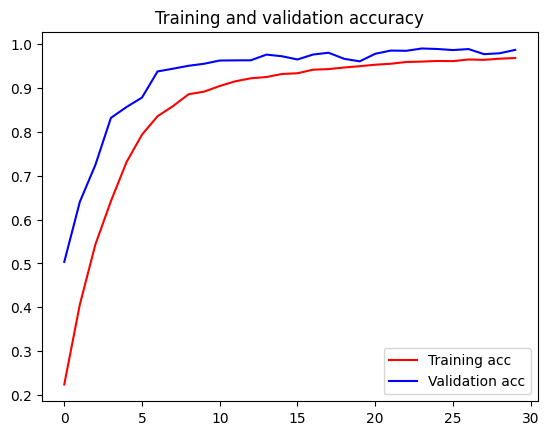

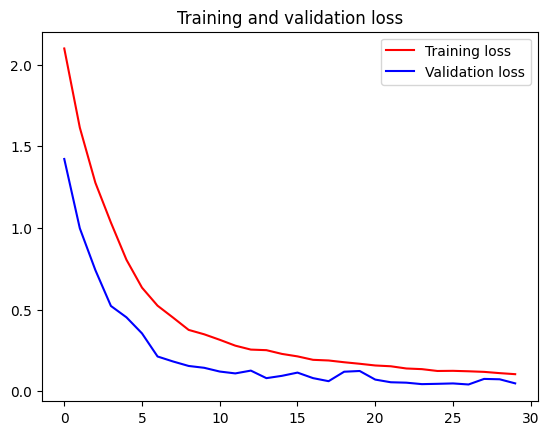

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
# 1. Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

185/185 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - acc: 0.9850 - loss: 0.0507
Test Accuracy: 0.9820
 Test Loss: 0.0612


In [29]:
# 2. Predictions
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

185/185 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step


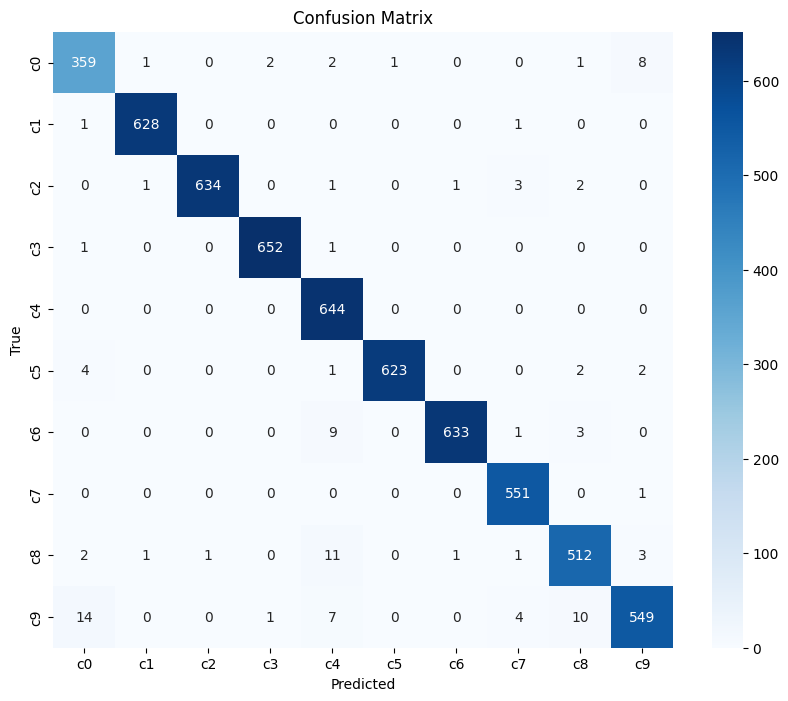

In [30]:
# 3. Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [31]:
from sklearn.metrics import classification_report
print("\n Classification Report:\n")
print(classification_report(test_generator.classes, y_pred,
                            target_names=list(test_generator.class_indices.keys())))


 Classification Report:

              precision    recall  f1-score   support

          c0       0.94      0.96      0.95       374
          c1       1.00      1.00      1.00       630
          c2       1.00      0.99      0.99       642
          c3       1.00      1.00      1.00       654
          c4       0.95      1.00      0.98       644
          c5       1.00      0.99      0.99       632
          c6       1.00      0.98      0.99       646
          c7       0.98      1.00      0.99       552
          c8       0.97      0.96      0.96       532
          c9       0.98      0.94      0.96       585

    accuracy                           0.98      5891
   macro avg       0.98      0.98      0.98      5891
weighted avg       0.98      0.98      0.98      5891



In [32]:
# 5. Per-class accuracy
cm_diag = np.diag(cm) / np.sum(cm, axis=1)
for idx, cls in enumerate(test_generator.class_indices.keys()):
    print(f"Class {cls}: {cm_diag[idx]*100:.2f}% accuracy")

Class c0: 95.99% accuracy
Class c1: 99.68% accuracy
Class c2: 98.75% accuracy
Class c3: 99.69% accuracy
Class c4: 100.00% accuracy
Class c5: 98.58% accuracy
Class c6: 97.99% accuracy
Class c7: 99.82% accuracy
Class c8: 96.24% accuracy
Class c9: 93.85% accuracy
